# 16-QAM communication inside Python

In [1]:
import numpy as np
import commpy as cp
import scipy.signal as sig
import math
import cmath
import statistics

#### Signal power

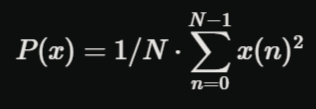

In [ ]:
def signalPower(x):
    return statistics.mean(np.square(x))

#### SNR defininition




##### Ps = Transmitted signal
##### Pn = Noise signal+Noise signal

In [ ]:
def SINR(signal, noise):
    powS = signalPower(signal)
    powN = signalPower(noise)
    return 10*math.log10((powS)/(powN-powS))

## Transmission 

#### Bitstream Generation

##### data bits size= N
##### Sync databits size = data_sync

In [ ]:
def dataGenerator(N, Synq=0):
   if Synq == 0:
      SynqTemp = []
      
      for i in range(176):
            SynqTemp.append(1)
      
      SynqSymb = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]
      
      Synq = np.concatenate((SynqTemp, SynqSymb), axis=None)
      
   Temp = np.random.rand(N - len(Synq))
   Temp[np.where(Temp >= 0.5)] = 1
   Temp[np.where(Temp < 0.5)] = 0
   
   Out = np.concatenate((Synq, Temp), axis=None)
   return(Out)

##### We slice the bitstream into odd and even positions

In [ ]:
def Slice(bits):
   BitsQuadrature = bits[
      slice(1, len(bits), 2)
      ]
   BitsInphase = bits[
      slice(0, len(bits), 2)
      ]
   
   return(BitsInphase, BitsQuadrature)

#### Modulating FSK

In [ ]:
def modulatingFSK(bits, Fsk):
    t = np.arange(start=0, stop=1, step=1/Fsk)
    DataFSK=[]

    for i in range(len(data)):
        #f.append(Fsk[int(i)])
        DataFSK.append(np.sin(pi*Fsk[int(data[i])]*t[i]/180.))
    return DataFSK

##### Modulating 64-QAM

In [ ]:
def Modulator64QAM(QAM64Vect, dataIn):
   Index = 4*dataIn[slice(0, len(dataIn), 3)] + 2*dataIn[slice(1, len(dataIn), 3)]+dataIn[slice(2, len(dataIn), 3)]
   
   Index = list(map(int, Index))
   
   Modulated = []
   
   for i in range(len(Index)):
      
      Modulated.append(QAM64Vect[Index[i]])
      
   return(Modulated)

##### Modulating the bits to 16-QAM

In [ ]:
def Modulator16QAM(QAM16Vect, dataIn):
   Index = 2*dataIn[slice(0, len(dataIn), 2)] + dataIn[slice(1, len(dataIn), 2)]
   
   Index = list(map(int, Index))
   
   Modulated = []
   
   for i in range(len(Index)):
      
      Modulated.append(QAM16Vect[Index[i]])
      
   return(Modulated)

##### Modulating QPSK/4-QAM

In [ ]:
def ModulatorQPSK(QPSKVect, dataIn):
   Index = dataIn
   
   Index = list(map(int, Index))
   
   Modulated = []
   
   for i in range(len(Index)):
      
      Modulated.append(QPSKVect[Index[i]])
      
   return(Modulated)

##### Modulating the bits to 8-QAM

In [ ]:
def Modulator8QAM(QAM8Vect, dataIn):
   Quadrature= QAM8Vect[0]
   Inphase= QAM8Vect[1]

   # Index = list(map(int, Index))

   Modulated = [[],[]]

   for i in range(0,len(dataIn),3):
      sample= list(map(int,dataIn[i:i+3]))


      if(sample==[0,0,0]):
         Modulated[0].append(Inphase[0])
         Modulated[1].append(Quadrature[1])
         
      elif(sample==[0,0,1]):
         Modulated[0].append(Inphase[1])
         Modulated[1].append(Quadrature[1])

      elif(sample==[0,1,0]):
         Modulated[0].append(Inphase[2])
         Modulated[1].append(Quadrature[1])
         

      elif(sample==[0,1,1]):
         Modulated[0].append(Inphase[3])
         Modulated[1].append(Quadrature[1])

      elif(sample==[1,0,0]):
         Modulated[0].append(Inphase[0])
         Modulated[1].append(Quadrature[0])

      elif(sample==[1,0,1]):

         Modulated[0].append(Inphase[1])
         Modulated[1].append(Quadrature[0])
         
      elif(sample==[1,1,0]):
         Modulated[0].append(Inphase[2])
         Modulated[1].append(Quadrature[0])

      elif(sample==[1,1,1]):         
         Modulated[0].append(Inphase[3])
         Modulated[1].append(Quadrature[0])

   return Modulated

##### 8-PSK modulator

In [ ]:
def Modulator8PSK(PSK8, dataIn):



   # Index = list(map(int, Index))

   Modulated = [[],[]]

   for i in range(0,len(dataIn),3):
      sample= list(map(int,dataIn[i:i+3]))


      if(sample==[0,0,0]):
         Modulated[0].append(PSK8[0])
         Modulated[1].append(PSK8[2])
         
      elif(sample==[0,0,1]):
         Modulated[0].append(PSK8[1])
         Modulated[1].append(PSK8[3])

      elif(sample==[0,1,0]):
         Modulated[0].append(PSK8[2])
         Modulated[1].append(PSK8[4])
         

      elif(sample==[0,1,1]):
         Modulated[0].append(PSK8[3])
         Modulated[1].append(PSK8[3])

      elif(sample==[1,0,0]):
         Modulated[0].append(PSK8[4])
         Modulated[1].append(PSK8[2])

      elif(sample==[1,0,1]):

         Modulated[0].append(PSK8[3])
         Modulated[1].append(PSK8[1])
         
      elif(sample==[1,1,0]):
         Modulated[0].append(PSK8[2])
         Modulated[1].append(PSK8[0])

      elif(sample==[1,1,1]):         
         Modulated[0].append(PSK8[1])
         Modulated[1].append(PSK8[1])

   return Modulated

##### Upsampling if necessacry

In [ ]:
def Upsampler(Ns, K, symbols):
   Out = np.zeros(Ns*K)
   
   Out[slice(0, len(Out), K)] = symbols
   
   return(Out)

#### Pulse shapping the signal

In [ ]:
def PulseShapping(Data, Ns, alpha, Fif, Fs):
   [x_axis, y_response] = cp.rrcosfilter(Ns, alpha, 2/Fif, Fs)
   shaped_signal = np.convolve(Data, y_response, 'full')
   return(shaped_signal, x_axis, y_response)


##### Carrier frequency  generator

In [ ]:
def CarrierGen(start, stop, step, frequency, phase=0):
   t = np.arange(start, stop, step)
   Osc = np.sin(2*math.pi*frequency*t + phase)
   return(Osc, t)

##### Mixer to apply carrier elements to the signal

In [ ]:
def Mixer(signal, carrier):
   mix = []
   for i in range(len(signal)):
      mix.append(signal[i]*carrier[i])
   return(mix)

##### Combine Quarature and Inphase signas

In [ ]:
def combiner(signal_I, signal_Q):
   combined_sig = []
   for i in range(len(signal_I)):
      combined_sig.append(signal_I[i] + signal_Q[i])
   return(combined_sig)

## Channel

##### Generating AWGN noise

In [ ]:
def AWGN(IFsig, SNR):
   dP = np.zeros(len(IFsig))
   P = 0

   for i in range(len(IFsig)):
      dP[i] = abs(IFsig[i])**2
      P = P + dP[i]

   P = P/len(IFsig)
   gamma = 10**(SNR/10)
   N0 = P/gamma
   n = ((N0/2)**(0.5))*np.random.standard_normal(len(IFsig))
   IF_n = np.zeros(len(IFsig))

   for i in range(len(IFsig)):
      IF_n[i] = IFsig[i] + n[i]

   return(IF_n)

## Reciever

##### Carrier signal synchronization

In [ ]:
def PLL(input_signal, Fs, lenght, N):
   zeta = .707  # damping factor
   k = 1
   Bn = 0.01*Fs  #Noise Bandwidth
   K_0 = 1  # NCO gain
   K_d = 1/2  # Phase Detector gain
   K_p = (1/(K_d*K_0))*((4*zeta)/(zeta+(1/(4*zeta)))) * \
      (Bn/Fs)  # Proporcional gain
   K_i = (1/(K_d*K_0))*(4/(zeta+(1/(4*zeta)**2))) * \
      (Bn/Fs)**2  # Integrator gain
   integrator_out = 0
   phase_estimate = np.zeros(lenght)
   e_D = []  # phase-error output
   e_F = []  # loop filter output
   sin_out_n = np.zeros(lenght)
   cos_out_n = np.ones(lenght)
   for n in range(lenght-1):
      # phase detector
      try:
            e_D.append(
               math.atan(input_signal[n] * (cos_out_n[n] + sin_out_n[n])))
      except IndexError:
            e_D.append(0)
      # loop filter
      integrator_out += K_i * e_D[n]
      e_F.append(K_p * e_D[n] + integrator_out)
      # NCO
      try:
            phase_estimate[n+1] = phase_estimate[n] + K_0 * e_F[n]
      except IndexError:
            phase_estimate[n+1] = K_0 * e_F[n]
      sin_out_n[n+1] = -np.sin(2*np.pi*(k/N)*(n+1) + phase_estimate[n])
      cos_out_n[n+1] = np.cos(2*np.pi*(k/N)*(n+1) + phase_estimate[n])

   sin_out_n = -sin_out_n
   cos_out = cos_out_n[280:400]
   sin_out = sin_out_n[280:400]

   for i in range(18):
      cos_out = np.concatenate(
            (cos_out, cos_out_n[280:400], cos_out_n[280:400]), axis=None)
      sin_out = np.concatenate(
            (sin_out, sin_out_n[280:400], sin_out_n[280:400]), axis=None)
   return(cos_out, sin_out)

##### We already have the mixer algorithm

##### Low pass filter 

In [ ]:
def LPF(signal, fc, Fs,o=5):
   
    # order of the filter
    
   fc = np.array([fc])
   
   Band = 2*fc/Fs

   [Num, Din] = sig.butter(o, Band, btype='loWpass')
   [W, h] = sig.freqz(Num, Din, worN=1024)

   W = Fs*W/(2*math.pi)

   signal_filt = sig.lfilter(Num, Din, signal)
   
   return(signal_filt, W, h)

##### Matched filter

In [ ]:
def MatchedFil(signal, template):
   
   signal_filt = np.convolve(signal, template, 'full')
   
   return(signal_filt)

#### Downsampler

In [ ]:
def DownSamp(signal, packet_s, upsampler_f,threshold = 4):
   e = 0
   gardner_e = []
   peak_sample = 0
   peak_sample_acc = []
   low_point = 0
   
   for i in range(len(signal)):
      if signal[low_point] < -threshold:
            if signal[i] > threshold:
               e = (abs(signal[(i+1)]) -
                     abs(signal[i-1])) * abs(signal[i])
               gardner_e.append(e)
               if e > 0.8:
                  peak_sample = peak_sample + 1
                  peak_sample_acc.append(peak_sample)
               elif e < -0.8:
                  peak_sample = peak_sample - 1
                  peak_sample_acc.append(peak_sample)
               else:
                  break
            else:
               peak_sample = peak_sample + 1
               peak_sample_acc.append(peak_sample)
      else:
            low_point = low_point + 1
            peak_sample = peak_sample + 1
            peak_sample_acc.append(peak_sample)

   # 450 is the number of samples before the convergence symbol of the algorithm.
   cut_i = peak_sample - 450
   cut_f = cut_i + int((packet_s/4)*upsampler_f)
   print("Cut_i = ", cut_i)
   print("Cut_f = ", cut_f)

   # For the code to still work, even when there is a big BER, this secction is required.
   if cut_i > 730:
      signal = signal[261:2306+510]
   elif cut_i < 690:
      signal = signal[261:2306+510]
   else:
      signal = signal[cut_i:cut_f]

   symbols = signal[slice(0, len(signal), upsampler_f)]
   return(symbols)

#### Demodulation of QPSK

In [ ]:
def demodulatorQPSK(symbols_I, symbols_Q, packetSize, threshold = 3.0):
    Ns = int(packetSize/2)
    

    bitStream = []

    for i in range(Ns):
        
        symbol_phase=cmath.phase(complex(symbols_I[i],symbols_Q[i]))
        
        if (symbol_phase<math.pi/2 and symbol_phase>=0):
            bitStream.append(1)
            bitStream.append(1)
            

        if (symbol_phase< math.pi and symbol_phase>= math.pi/2):
            bitStream.append(0)
            bitStream.append(1)
            
            
        if (symbol_phase< 0 and symbol_phase>=-math.pi/2):
            bitStream.append(1)
            bitStream.append(0)
            
            
        if (symbol_phase< -math.pi/2 and symbol_phase>=-math.pi):
            bitStream.append(0)
            bitStream.append(0)
            
        
 
            
    return(bitStream)

#### Demodulation of 64-QAM

In [ ]:
def demodulator64QAM(symbols_I, symbols_Q, packetSize, threshold = 10.0):
    Ns = int(packetSize/6)
    bits_I = []
    bits_Q = []
    for i in range(Ns):
        if symbols_I[i] >= 0 and symbols_I[i] <= threshold:
             bits_I.append(1)
             bits_I.append(0)
             bits_I.append(0)   
        if symbols_I[i] > threshold and symbols_I[i] <= 2*threshold:
             bits_I.append(1)
             bits_I.append(0)
             bits_I.append(1)
             
        if symbols_I[i] > 2*threshold and symbols_I[i] <= 3*threshold:
             bits_I.append(1)
             bits_I.append(1)
             bits_I.append(0)
        
        if symbols_I[i] > 3*threshold:
             bits_I.append(1)
             bits_I.append(1)
             bits_I.append(1)
        
        if symbols_I[i] >= -threshold and symbols_I[i] < 0:
             bits_I.append(0)
             bits_I.append(1)
             bits_I.append(1)
             
        if symbols_I[i] >= -2*threshold and symbols_I[i] < -threshold:
             bits_I.append(0)
             bits_I.append(1)
             bits_I.append(0)
             
        if symbols_I[i] >= -3*threshold and symbols_I[i] < -2*threshold:
             bits_I.append(0)
             bits_I.append(0)
             bits_I.append(1)   
             
        if symbols_I[i] < -3*threshold:
             bits_I.append(0)
             bits_I.append(0)
             bits_I.append(0) 
          
        
        
        if symbols_Q[i] >= 0 and symbols_Q[i] <= threshold:
             bits_Q.append(1)
             bits_Q.append(0)
             bits_Q.append(0)   
        if symbols_Q[i] > threshold and symbols_Q[i] <= 2*threshold:
             bits_Q.append(1)
             bits_Q.append(0)
             bits_Q.append(1)
             
        if symbols_Q[i] > 2*threshold and symbols_Q[i] <= 3*threshold:
             bits_Q.append(1)
             bits_Q.append(1)
             bits_Q.append(0)
        
        if symbols_Q[i] > 3*threshold:
             bits_Q.append(1)
             bits_Q.append(1)
             bits_Q.append(1)
        
        if symbols_Q[i] >= -threshold and symbols_Q[i] < 0:
             bits_Q.append(0)
             bits_Q.append(1)
             bits_Q.append(1)
             
        if symbols_Q[i] >= -2*threshold and symbols_Q[i] < -threshold:
             bits_Q.append(0)
             bits_Q.append(1)
             bits_Q.append(0)
             
        if symbols_Q[i] >= -3*threshold and symbols_Q[i] < -2*threshold:
             bits_Q.append(0)
             bits_Q.append(0)
             bits_Q.append(1)   
             
        if symbols_Q[i] < -3*threshold:
             bits_Q.append(0)
             bits_Q.append(0)
             bits_Q.append(0)
        
         
    bits_I = list(map(int, bits_I))
    bits_Q = list(map(int, bits_Q)) 
    bitStream = np.zeros(packetSize)    
    
    for i in range(len(bits_I)):
       bitStream[2*i] = bits_I[i]
       bitStream[2*i-1] = bits_Q[i-1]
    return(bitStream)

#### Demodulation 16-QAM

In [ ]:
def demodulator16QAM(symbols_I, symbols_Q, packetSize, threshold = 3.0):
   Ns = int(packetSize/4)
   bits_I = []
   bits_Q = []
   for i in range(Ns):
      if symbols_I[i] >= 0 and symbols_I[i] <= threshold:
            bits_I.append(1)
            bits_I.append(0)

      if symbols_I[i] > threshold:
            bits_I.append(1)
            bits_I.append(1)

      if symbols_I[i] < 0 and symbols_I[i] >= -threshold:
            bits_I.append(0)
            bits_I.append(1)

      if symbols_I[i] < -threshold:
            bits_I.append(0)
            bits_I.append(0)

      if symbols_Q[i] >= 0 and symbols_Q[i] <= threshold:
            bits_Q.append(1)
            bits_Q.append(0)

      if symbols_Q[i] > threshold:
            bits_Q.append(1)
            bits_Q.append(1)

      if symbols_Q[i] < 0 and symbols_Q[i] >= -threshold:
            bits_Q.append(0)
            bits_Q.append(1)

      if symbols_Q[i] < -threshold:
            bits_Q.append(0)
            bits_Q.append(0)

   bits_I = list(map(int, bits_I))
   bits_Q = list(map(int, bits_Q))

   bitStream = np.zeros(packetSize)

   for i in range(len(bits_I)):
      bitStream[2*i] = bits_I[i]
      bitStream[2*i-1] = bits_Q[i-1]
   return(bitStream)

##### Demodulation of 8-QAM

In [ ]:
def demodulator8QAM(symbols_I, symbols_Q, packetSize, threshold = 3.0):
    Ns = int(packetSize/3)
    # bits_I = []
    # bits_Q = []

    bitStream = []

    for i in range(Ns):
        if (symbols_I[i] < 0 and symbols_I[i] >= -threshold and symbols_Q[i] >=0):
            bitStream.append(0)
            bitStream.append(0)
            bitStream.append(1)

        if (symbols_I[i] < -threshold and symbols_Q[i] >=0):
            bitStream.append(0)
            bitStream.append(0)
            bitStream.append(0)

        if (symbols_I[i] >= threshold and symbols_Q[i] >=0):
            bitStream.append(0)
            bitStream.append(1)
            bitStream.append(1)

        if (symbols_I[i] >= 0 and symbols_I[i] < threshold and symbols_Q[i] >=0):
            bitStream.append(0)
            bitStream.append(1)
            bitStream.append(0)

        if (symbols_I[i] >= 0 and symbols_I[i] < threshold and symbols_Q[i] <0):
            bitStream.append(1)
            bitStream.append(1)
            bitStream.append(0)

        if (symbols_I[i] >= threshold and symbols_Q[i] <0):
            bitStream.append(1)
            bitStream.append(1)
            bitStream.append(1)

        if (symbols_I[i] < 0 and symbols_I[i] >= -threshold and symbols_Q[i] <0):
            bitStream.append(1)
            bitStream.append(0)
            bitStream.append(1)

        if (symbols_I[i] < -threshold and symbols_Q[i] <0):
            bitStream.append(1)
            bitStream.append(0)
            bitStream.append(0)

 
            
    return(bitStream)

#### 8-PSK Demodulation

In [ ]:
def demodulator8PSK(symbols_I, symbols_Q, packetSize, threshold = 3.0):
    Ns = int(packetSize/3)
    

    bitStream = []

    for i in range(Ns):
        
        symbol_phase=cmath.phase(complex(symbols_I[i],symbols_Q[i]))
        
        if (symbol_phase<0.3926 and symbol_phase>=-0.3926):
            bitStream.append(1)
            bitStream.append(0)
            bitStream.append(0)

        if (symbol_phase< 1.178 and symbol_phase>=0.3926):
            bitStream.append(0)
            bitStream.append(1)
            bitStream.append(1)
            
        if (symbol_phase< 1.9634 and symbol_phase>=1.178):
            bitStream.append(0)
            bitStream.append(1)
            bitStream.append(0)
            
        if (symbol_phase< 2.7488 and symbol_phase>=1.9634):
            bitStream.append(0)
            bitStream.append(0)
            bitStream.append(1)
        
        if (symbol_phase< -2.7488 or symbol_phase>=2.7488):
            bitStream.append(0)
            bitStream.append(0)
            bitStream.append(0)
            
        if (symbol_phase<-1.9634 and symbol_phase>=-2.7488):
            bitStream.append(1)
            bitStream.append(1)
            bitStream.append(1)
            
            
        if (symbol_phase<-1.178 and symbol_phase>=-1.9634):
            bitStream.append(1)
            bitStream.append(1)
            bitStream.append(0)

        if (symbol_phase<-0.3926 and symbol_phase>=-1.178):
            bitStream.append(1)
            bitStream.append(0)
            bitStream.append(1)
 
            
    return(bitStream)

### Code to generate the whole Transmitted signal

In [ ]:
import numpy as np
from math import pi
import scipy.fftpack as sf

In [ ]:
def QAMsys(SNR, plot = 1, K=10, Ns=256, alpha=0.3, Bs=4,ConstellationVect = [-1, -0.333, 0.333, 1],Fif = 2e6):
   
#    # Upsampler Factor
#    K = 10

#    # Number of symbols
#    Ns = 256

#    # Roll-off factor
#    alpha = 0.3

#    # Bits per symbol
#    Bs = 4

   

   # Intermediary frequency
   Fif = 2e6

   # Sampling Rate
   Fs = Fif * K / 2
   
   # 16QAM Constellation vector
   QAM16 = ConstellationVect

   # Pseudo-Rand Generator with synchronization bits
   data = dataGenerator(Ns * Bs)

   # Slicer
   (dataI, dataQ) = Slice(data)

   # Mapper
   mapI = Modulator16QAM(QAM16, dataI)
   mapQ = Modulator16QAM(QAM16, dataQ)

   # Up-sampler
   upI = Upsampler(Ns, K, mapI)
   upQ = Upsampler(Ns, K, mapQ)

   # Shaping filter
   [shape_I, a, b] = PulseShapping(upI, Ns, alpha, Fif, Fs)
   [shape_Q, a, b] = PulseShapping(upQ, Ns, alpha, Fif, Fs)

   template = b

   # Oscillator
   delta_phase = np.random.normal(0, np.pi / 3, 1)
   delta_freq = np.random.normal(0, 20, 1)

   (loCos_TX, t) = CarrierGen(0, 4e-4, 2 /
                                 (Fif * K),  Fif + delta_freq, delta_phase + np.pi / 2)
   (loSin_TX, t) = CarrierGen(0, 4e-4, 2 /
                                 (Fif * K),  Fif + delta_freq, delta_phase)

   # Mixers
   mixI = Mixer(shape_I, loCos_TX)
   mixQ = Mixer(shape_Q, loSin_TX)

   # Combiner
   IF = combiner(mixI, mixQ)
   
   return IF
   
